__Warning__
********************************

_LSFMs only evaluate SFs for a fixed target policy that selects actions uni-formly at random.  The learned model can then be used to predict the valuefunction of any arbitrary policy, including the optimal policy._

_LSFMs do not include a value prediction module_

_test different alpha for the loss_ : results : alpha_N = 1.0 / alpha_psi = 0.01

*********************************

__BUGS__
Attention : ne pas faire de _reset_LSFM_ : probleme d'allocation de nouveau tenseur je pense

# Environment

In [1]:
import gym
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, Input


import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid


In [2]:
class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.state_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"],
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
            )

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            self.action_space = gym.spaces.Discrete(4)
            
        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = self.observation_space.n
        else:
            self._state_dim = len(observation)

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"] ,
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
                )
                                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig, ax = plt.subplots()
            ax.imshow(self.env.grid)

            # Minor ticks
            ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
            ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agents

## LSFM

In [3]:

class Agent:
    
        
    def __init__(self, enviroment, param={}):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]
        
#         LSFM model for construction of a reward-predictive space representation  
#         LSFM must be train on policy independant of state
        inputs = Input(shape=(self._state_dim,), name="input")
        x = layers.Dense(30, activation='relu', name="hidden_latent")(inputs)
        layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
        layers_ouputs = {}

        x = layers.Dense(self.dim_latent * self._action_size,use_bias=False, name = "Fa")(layer_latent)
        layers_ouputs["Fa"] = layers.Reshape((self._action_size, self.dim_latent))(x)
        layers_ouputs["ra"]  = layers.Dense(self._action_size,use_bias=False, name = "ra")(layer_latent)

        
#         layers_ouputs["dot_reward"] = layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
        layers_ouputs["phi"] = layer_latent    
        self.model_LSFM = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model_LSFM")     
        self.model_LSFM_prev = keras.models.clone_model(self.model_LSFM)
        
#         DQN model using the original state space
        self.model_DQN = keras.Sequential()
        self.model_DQN.add(layers.Dense(30, activation="relu"))
        self.model_DQN.add(layers.Dense(self._action_size))
        self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

#         DQN model using the latent state space
        self.model_DQN_latent = keras.Sequential()
        self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
        self.model_DQN_latent.add(layers.Dense(self._action_size))
        self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
#         Linear Q model using the original state space  
        self.model_LinQN = keras.Sequential()
        self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

#         Linear model using the latent state space
        self.model_LinQN_latent = keras.Sequential()
        self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]


#     def reset_models_LSFM(self):
# #         LSFM model for construction of a reward-predictive space representation  
# #         LSFM must be train on policy independant of state
#         inputs = Input(shape=(self._state_dim,), name="input")
#         x = layers.Dense(30, activation='relu', name="hidden_latent")(inputs)
#         layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
#         layers_ouputs = {}

#         x = layers.Dense(self.dim_latent * self._action_size,use_bias=False, name = "Fa")(layer_latent)
#         layers_ouputs["Fa"] = layers.Reshape((self._action_size, self.dim_latent))(x)
#         layers_ouputs["ra"]  = layers.Dense(self._action_size,use_bias=False, name = "ra")(layer_latent)

        
# #         layers_ouputs["dot_reward"] = layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
#         layers_ouputs["phi"] = layer_latent    
#         self.model_LSFM = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model_LSFM")     
#         self.model_LSFM_prev = keras.models.clone_model(self.model_LSFM)
    
#     def reset_optimizer_LSFM(self):
#         self.param["optimizer_LSFM"] = keras.optimizers.Adam()
        
        
    
    def update_param(self,param ):
        
        self.param = param
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]

# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.      

        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]


#     def reset_models_Q(self):
        
# #         DQN model using the original state space
#         self.model_DQN = keras.Sequential()
#         self.model_DQN.add(layers.Dense(30, activation="relu"))
#         self.model_DQN.add(layers.Dense(self._action_size))
#         self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

# #         DQN model using the latent state space
#         self.model_DQN_latent = keras.Sequential()
#         self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
#         self.model_DQN_latent.add(layers.Dense(self._action_size))
#         self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
# #         Linear Q model using the original state space  
#         self.model_LinQN = keras.Sequential()
#         self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
#         self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

# #         Linear model using the latent state space
#         self.model_LinQN_latent = keras.Sequential()
#         self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
#         self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
    def target_psi(self, model, states,actions, next_states,terminate,rewards, filter_done, action_space):

        psi = model(states)["Fa"]
        
        psi_prime = model(next_states)["Fa"]
        
        psi_bar = tf.math.reduce_mean(psi_prime, axis=1 )
        
        phi = model(states)["phi"] 
        
#         if model_prev is None:
#             psi_bar = self.psi_bar(next_states, action_space, model) 
#         else : 
#             psi_bar = self.psi_bar_prev(next_states, action_space, model, model_prev         
        #  filter_done = True : - we don't take into account terminal states : 
        #                       - creation of a filter to determine whitch episode of batch is a terminal state
        #  filter_done = False : we take into account all states
        
        if filter_done  : 
            
            gamma_psibar = tf.multiply(self.param["gamma"],psi_bar)
            
            filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)

            filter_expand  = tf.transpose(tf.tile(
                tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
            ))

            gamma_psibar_filter = tf.math.multiply(filter_expand, gamma_psibar)
            
            y = tf.add(
                phi, 
                gamma_psibar_filter
            )
            
        else : 
            
            y = tf.add(
                phi, 
                tf.multiply(
                        self.param["gamma"],
                        psi_bar
                ) 
            )
            
        return y
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        
    def loss_N(self,y_pred) : 
        vector_ONE = tf.constant(1., shape=y_pred.shape[0], dtype = y_pred.dtype)
        loss =    tf.pow(tf.subtract(tf.norm(y_pred, axis=1), vector_ONE ), 2.) 
        return loss
        
        

#         agent.train_LSFM(
#                         model_LSFM, 
#                         memory, 
#                         model_LSFM_prev if param_agent["double_model"] else None, 
#                         param_agent["filter_done"])
    
    def train_LSFM(self, model, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return [0,0,0,0]
        batch = memory.sample(self.batch_size)
        
        action_space = np.arange(self._action_size)
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[3]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))

        
        #         ************* A Calculate Loss on reward and normalisation first  *******************
        # 1) calculate the losses 
            
        target_psi = self.target_psi(model, states,actions, next_states,terminate,rewards, filter_done, action_space)
        
        
        alpha_r = self.param["alpha_r"]
        alpha_N = self.param["alpha_N"]
        alpha_psi = self.param["alpha_psi"]  
        
        with tf.GradientTape() as tape:
            logits_r = self.get_from_actions( states, actions, model, "ra")
            loss_r =  self.loss_mse(logits_r, rewards )

            logits_N = model(states)["phi"]
            loss_N =  self.loss_N(logits_N)

            logits_psi = self.get_from_actions( states, actions, model, "Fa")
            loss_psi = self.loss_mse( logits_psi, target_psi )

            loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi
        
        # 2) : calculate the gradient   
        grads = tape.gradient(loss_tot, model.trainable_weights) 
        
#         print("grads", grads)

        # 3) : apply the gradient 
        self.param["optimizer_LSFM"].apply_gradients(zip(grads, model.trainable_weights)) 
          
        #         ****************************************************

#         if model_prev is not None:
#             # update model_prev parameters slowly from model (primary network) 
#             for t, e in zip(model_prev.trainable_variables, model.trainable_variables):
#                 t.assign(
#                     tf.add(
#                         tf.multiply(
#                             t,(1 - self.param["tau"]) 
#                         ), 
#                         tf.multiply(
#                             e , self.param["tau"]  
#                         )
#                     ) 
#                 )
        
        return [tf.reduce_mean(loss_tot).numpy(), 
                tf.reduce_mean(loss_r).numpy(), 
                tf.reduce_mean(loss_N).numpy(), 
                tf.reduce_mean(loss_psi).numpy()]

    

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************
    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([val[3] for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss_mse(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

## Qlearning

In [4]:
# self._state_dim = enviroment._state_dim


In [5]:

class Agent_Q:
    
        
    def __init__(self, enviroment, param = {}, save_model=None):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]

        
        if save_model == None : 
            if  param["model_Q_Lin"] : 
                print("Agent_Q.model : initialization model_Q_Lin")
                self.model = keras.Sequential()
                self.model.add(layers.Dense(self._action_size, use_bias=False))
                self.model_prev = keras.models.clone_model(self.model)
                

                
            else : 
                print("Agent_Q.model : initialization model_DQN")
            
                self.model = keras.Sequential()
                self.model.add(layers.Dense(30, activation="relu", name="latent"))
                self.model.add(layers.Dense(self._action_size))
                self.model_prev = keras.models.clone_model(self.model)

#              DQN model using the original state space
#             self.model_DQN = keras.Sequential()
#             self.model_DQN.add(layers.Dense(30, activation="relu"))
#             self.model_DQN.add(layers.Dense(self._action_size))
#             self.model_DQN_prev = keras.models.clone_model(self.model_DQN)


#     #         DQN model using the latent state space
#             self.model_DQN_latent = keras.Sequential()
#             self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
#             self.model_DQN_latent.add(layers.Dense(self._action_size))
#             self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)



#     #         Linear Q model using the original state space  
#             self.model_LinQN = keras.Sequential()
#             self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
#             self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)


#     #         Linear model using the latent state space
#             self.model_LinQN_latent = keras.Sequential()
#             self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
#             self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        else : 
            print("Agent_Q.model : load model ")

            self.model               = keras.models.load_model(save_model)
            self.model_prev          = keras.models.load_model(save_model)
            
            for i in range(len(self.model.layers)-1):
                print("layers name",i,  self.model.layers[i].name)
                self.model.layers[i].trainable = False  
                self.model_prev.layers[i].trainable = False  

            

#             for t in zip(self.model.trainable_variables):
#                 print("load model init : ", t)

#             self.model_DQN               = tf.keras.models.clone_model(save_model)
#             self.model_DQN_prev          = tf.keras.models.clone_model(save_model)
#             self.model_DQN_latent        = tf.keras.models.clone_model(save_model)
#             self.model_DQN_latent_prev   = tf.keras.models.clone_model(save_model)
#             self.model_LinQN             = tf.keras.models.clone_model(save_model)
#             self.model_LinQN_prev        = tf.keras.models.clone_model(save_model)
#             self.model_LinQN_latent      = tf.keras.models.clone_model(save_model)
#             self.model_LinQN_latent_prev = tf.keras.models.clone_model(save_model)

        
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************

    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([val[3] for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss_mse(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

# Storage

In [6]:

class Memory:
        
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)
            
    def reset(self):
        self._samples = []

    @property
    def num_samples(self):
        return len(self._samples)


# Visu environment and models

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 1.0
done True


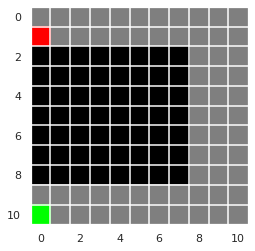

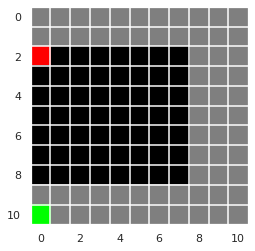

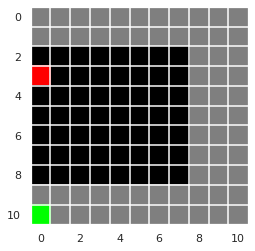

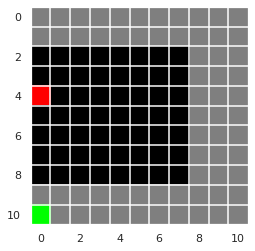

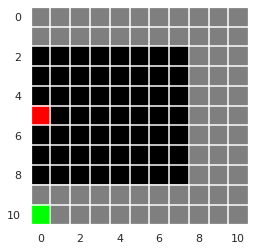

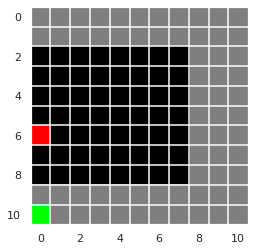

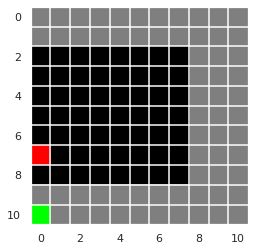

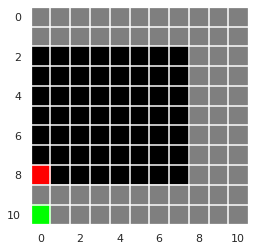

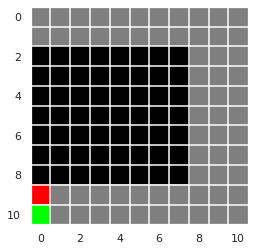

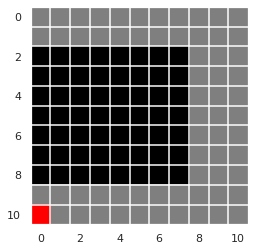

In [7]:

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[9,0] ],
#     "reward_minmax":[-1.,1.],
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9], 
#                                                             [2, 6],[2, 7],[2, 8],[2, 9], 
#                                                             [3, 6],[3, 7],[3, 8],[3, 9], 
#                                                             [4, 6],[4, 7],[4, 8],[4, 9], 
#                                                             [5, 6],[5, 7],[5, 8],[5, 9], 
#                                                             [6, 6],[6, 7],[6, 8],[6, 9], 
#                                                             [7, 6],[7, 7],[7, 8],[7, 9], 
#                   [8, 0],[8, 1],[8, 2],[8, 3],[8, 4],[8, 5],[8, 6],[8, 7],[8, 8],[8, 9], 
#                   [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9]],
#     "grid_size" : 10,
#     "pattern": "empty",
# #     "pattern":["user_defined", [ [2,0],[2,1],[2,2],[2,3],[2,4],[2,5],
# #                                [7,0],[7,1],[7,2],[7,3],[7,4],[7,5]]],
#     "obs_mode":"index",
# }

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[5,0] ],
#     "reward_minmax":[-1.,0.],
#     "reward_user_defined":True,
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
#                                               [2, 4],[2, 5], 
#                                               [3, 4],[3, 5], 
#                   [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
#                   [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
#     "grid_size" : 6,
#     "pattern": "empty",
#     "obs_mode":"index",
# }


param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[10,0] ],
    "reward_minmax":[-1.,0.],
    "reward_user_defined":True,
    "reward_pos":[
        [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
        [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
                                                                [2, 8],[2, 9],[2, 10],
                                                                [3, 8],[3, 9],[3, 10],
                                                                [4, 8],[4, 9],[4, 10],
                                                                [5, 8],[5, 9],[5, 10],
                                                                [6, 8],[6, 9],[6, 10],
                                                                [7, 8],[7, 9],[7, 10],
                                                                [8, 8],[8, 9],[8, 10],
        [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
        [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
                ],
    "grid_size" : 11,
    "pattern": "empty",
    "obs_mode":"index",
}



env_name = "SimpleGrid"
env = custom_env(env_name, param_env)


latent_dimension = int(env._state_dim / 2)

param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0002
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "num_episodes" : 100,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True
}

agent = Agent(env, param_agent)


state = env.reset()
actions_down = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(10) : 
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    env.render()
    
    state = next_state



In [8]:
def random_action(env) : 
    return random.randint(0, env.action_space.n - 1)

# models summary

## LSFM

Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 121)]        0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           3660        input[0][0]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 60)           1860        hidden_latent[0][0]              
__________________________________________________________________________________________________
Fa (Dense)                      (None, 240)          14400       latent[0][0]                     
_________________________________________________________________________________________

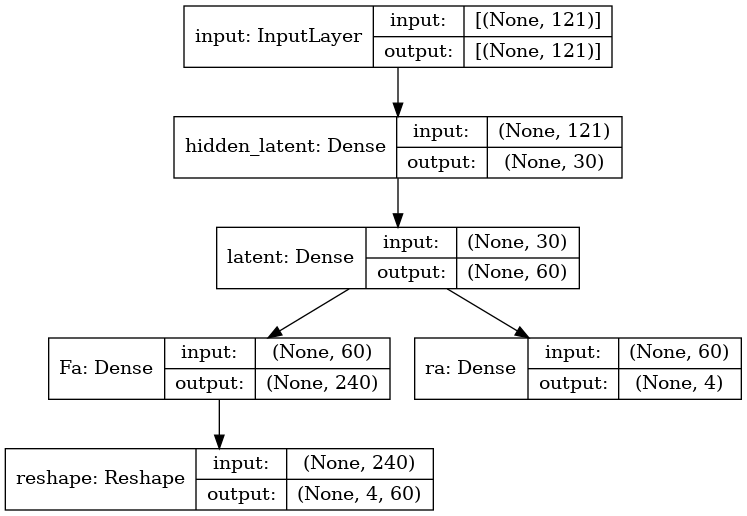

In [9]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

## Linear QLearning
Qlearning on latent space

### QLin on latent space

Agent_Q.model : initialization model_Q_Lin
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (32, 4)                   240       
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


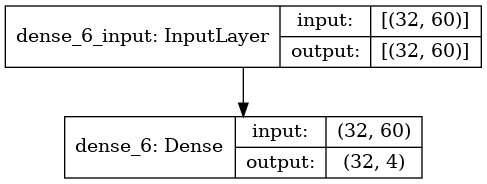

In [10]:
param_agent["model_Q_Lin"] = True

x= np.zeros((param_agent["batch_size"],param_agent["latent_space"]), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

### DQN on original space

Agent_Q.model : initialization model_DQN
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent (Dense)               (32, 30)                  3660      
_________________________________________________________________
dense_7 (Dense)              (32, 4)                   124       
Total params: 3,784
Trainable params: 3,784
Non-trainable params: 0
_________________________________________________________________


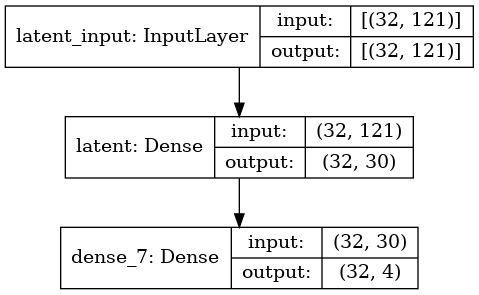

In [11]:
param_agent["model_Q_Lin"] = False

x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

# test 

In [12]:
# states_double = np.array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0.], 
#                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
#         0., 0., 0., 0.]])
# actions_double = np.array([0,1])

# states = np.array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0.]])
# actions = np.array([0])

# states_2 = np.array([ 
#                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
#         0., 0., 0., 0.]])
# actions_2 = np.array([1])


states_double = np.zeros((2,env._state_dim))
states_double[0,int(env._state_dim*1/3)] = 1
states_double[1,int(env._state_dim*2/3)] = 1

actions_double = np.array([0,1])

states = np.zeros((1,env._state_dim))
states[0,int(env._state_dim*1/3)]  = 1

actions = np.array([0])

states_2 = np.zeros((1,env._state_dim))
states_2[0,int(env._state_dim*2/3)]  = 1 
actions_2 = np.array([1])





# phi = agent.phi(states, agent.model_LSFM)
# phi

## reward 

In [13]:
phi = agent.model_LSFM(states_double)["phi"]
phi.shape

TensorShape([2, 60])

In [14]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "ra"
    if layer.name == name_a : 
        wa = layer.weights[0]
#         wa = tf.transpose(wa_transpose)

wa.shape

TensorShape([60, 4])

In [15]:
tf.matmul( phi , wa   )

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.02944615, -0.01035087,  0.03588234,  0.03549657],
       [ 0.00437582, -0.12202953, -0.09647138,  0.04589715]],
      dtype=float32)>

In [16]:
agent.model_LSFM(states_double)["ra"] == tf.matmul( phi , wa   )

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

## psi_bar


In [17]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "Fa"
    if layer.name == name_a :         
        Fa = layer.weights[0]

Fa.shape


TensorShape([60, 240])

In [18]:
Fa_reshape = tf.reshape(Fa, (Fa.shape[0],4,Fa.shape[0]))
Fa_reshape.shape

TensorShape([60, 4, 60])

In [19]:
phi = agent.model_LSFM(states_double)["phi"]
phi.shape

TensorShape([2, 60])

In [20]:
psi_batch = []

for b in range(2) : 
    phi_unique = tf.reshape(phi[b,:], (1,param_agent["latent_space"]))
    psi_unique = []
    for a in range(4) : 
        res = tf.matmul( phi_unique,Fa_reshape[:,a])
        res_reshape = tf.reshape(res, (param_agent["latent_space"]))
        psi_unique.append(res_reshape)
    psi_batch.append(psi_unique)
psi_scratch = tf.convert_to_tensor(psi_batch)

tf.norm(agent.model_LSFM(states_double)["Fa"]- psi_scratch, axis = 1)

<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[4.8616462e-09, 4.5806878e-09, 2.2812650e-09, 4.6566129e-09,
        3.8469934e-09, 2.3283063e-10, 3.5540055e-09, 2.1623185e-09,
        4.3682897e-09, 2.7939675e-09, 2.6341778e-09, 2.3744156e-09,
        3.8489265e-09, 9.2694661e-09, 5.4354854e-09, 2.7939675e-09,
        1.6789654e-09, 0.0000000e+00, 4.1650012e-09, 2.6341778e-09,
        4.2678558e-09, 1.9199706e-09, 5.5146958e-09, 5.2683555e-09,
        3.3579308e-09, 3.2345868e-09, 9.9465280e-10, 5.9633742e-09,
        3.3900649e-09, 2.5211377e-09, 1.3488612e-09, 2.0825006e-09,
        7.4505802e-09, 2.6367490e-09, 2.0825006e-09, 0.0000000e+00,
        2.1339279e-09, 3.7542809e-09, 5.2270348e-09, 2.1339279e-09,
        2.0062652e-09, 1.8626450e-09, 2.6341778e-09, 4.1650012e-09,
        4.0654831e-09, 3.7542809e-09, 2.0825006e-09, 2.2812650e-09,
        1.3170889e-09, 9.3132252e-10, 4.3682897e-09, 8.5357117e-09,
        1.7578328e-09, 3.7252901e-09, 4.9280957e-09, 4.1650012e-09,

## Fa_bar

In [21]:
Fa_bar = tf.math.reduce_mean(    Fa_reshape, axis=1 )
Fa_bar[:,:] == (Fa_reshape[:,0,:] + Fa_reshape[:,1,:] +Fa_reshape[:,2,:] +Fa_reshape[:,3,:] ) / 4
 
psi = agent.model_LSFM(states_double)["Fa"]

psi_bar = tf.math.reduce_mean(    psi, axis=1 )
psi_bar_scratch = tf.matmul( phi,Fa_bar)

tf.norm(psi_bar - psi_bar_scratch, axis = 0)
# Fa_reshape.mean()

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([1.9199706e-09, 1.0412503e-09, 2.0825006e-09, 1.6789654e-09,
       2.3283064e-09, 1.3170889e-09, 1.6789654e-09, 4.6566126e-10,
       1.0412503e-09, 0.0000000e+00, 1.8626450e-09, 1.1641532e-09,
       4.6566126e-10, 2.9816871e-09, 1.8626450e-09, 1.1641532e-09,
       2.6031259e-09, 0.0000000e+00, 1.8626450e-09, 1.8771404e-09,
       3.7325592e-09, 1.8626450e-09, 9.3132252e-10, 9.3132252e-10,
       1.8184656e-09, 9.3132252e-10, 9.3132252e-10, 1.6789654e-09,
       3.9512669e-09, 1.0412503e-09, 9.5998531e-10, 2.3283063e-10,
       1.8626450e-09, 2.3283064e-09, 1.9199706e-09, 1.8626450e-09,
       3.7542809e-09, 2.3283064e-09, 9.3132252e-10, 4.6566126e-10,
       2.6341778e-09, 2.9451006e-09, 5.2062515e-10, 2.8036520e-09,
       2.6341778e-09, 2.0825006e-09, 9.5998531e-10, 1.8184656e-09,
       1.4725503e-09, 4.6566126e-10, 1.8626450e-09, 1.3170889e-09,
       1.9514763e-09, 0.0000000e+00, 2.0825006e-09, 2.0825006e-09,
       9.313225

## filter 

In [22]:


terminate = [ True,  False]

filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)


gamma = 0.9
gamma_psibar = tf.multiply(gamma,psi_bar)

filter_expand  = tf.transpose(tf.tile(
    tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
))


tf.math.multiply(filter_expand, gamma_psibar)

# tf.matmul( gamma_psibar,filter_expand)



<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        ,  0.        ],
       [ 0.00446206, -0.0053972 ,  0.00611531, -0.00222602, -0.02796457,
 

# Train

## environments

### first (puddle word)

action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -0.001
done False
action 1
 0 - Up  /  1 - Down  /  2 - Le

<ipython-input-2-f4e8a8cce243>:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


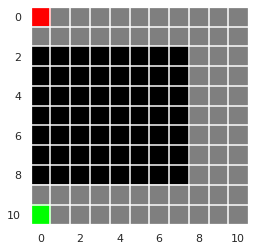

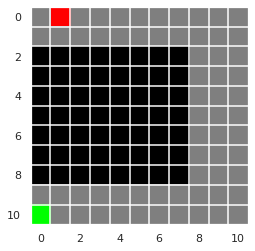

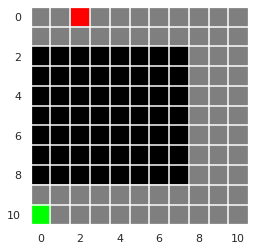

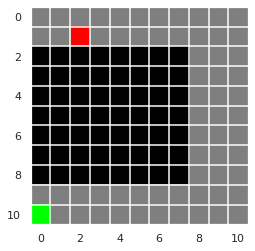

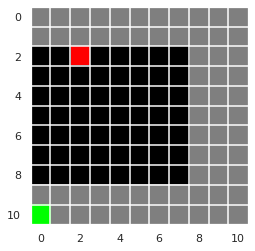

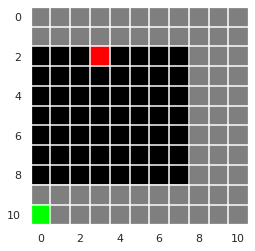

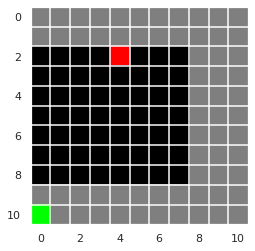

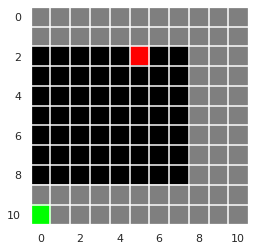

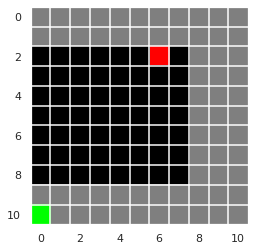

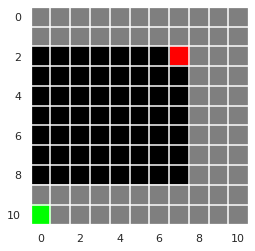

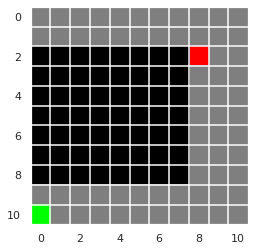

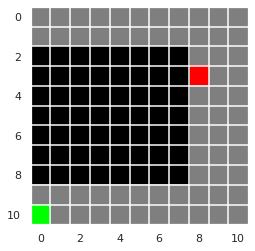

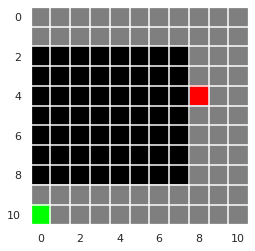

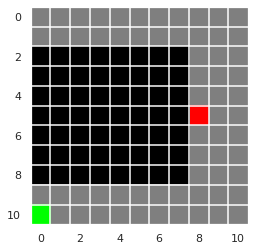

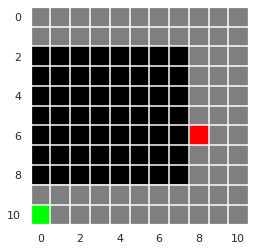

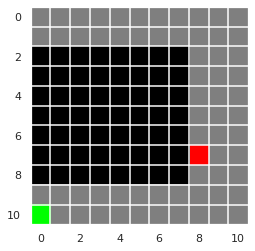

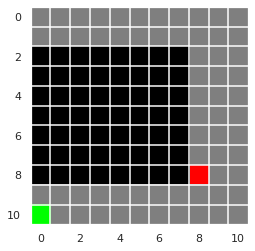

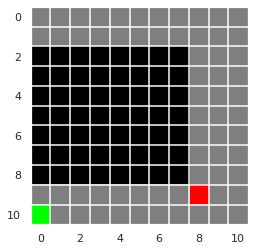

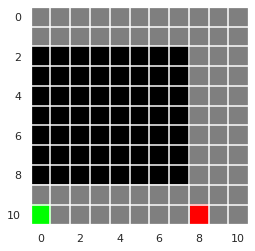

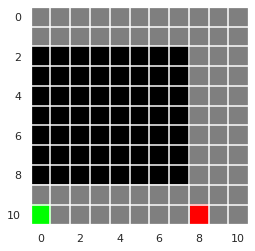

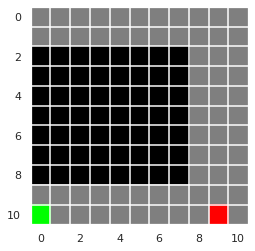

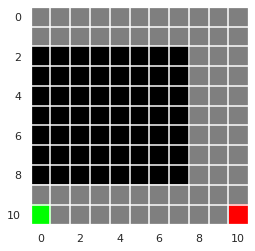

In [23]:

param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[10,0] ],
    "reward_minmax":[-1.,-0.001],
    "reward_user_defined":True,
    "reward_pos":[
        [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
        [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
                                                                [2, 8],[2, 9],[2, 10],
                                                                [3, 8],[3, 9],[3, 10],
                                                                [4, 8],[4, 9],[4, 10],
                                                                [5, 8],[5, 9],[5, 10],
                                                                [6, 8],[6, 9],[6, 10],
                                                                [7, 8],[7, 9],[7, 10],
                                                                [8, 8],[8, 9],[8, 10],
        [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
        [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
                ],
    "grid_size" : 11,
    "pattern": "empty",
    "obs_mode":"index",
}


env_name = "SimpleGrid"
env = custom_env(env_name, param_env)


state = env.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]
for i in range(22) : 
    env.render()
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state


### second (four room)

action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0

<ipython-input-2-f4e8a8cce243>:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 1.0
done True


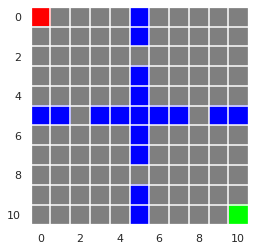

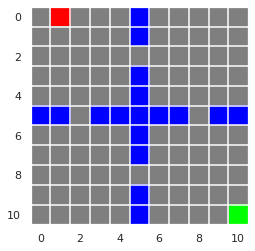

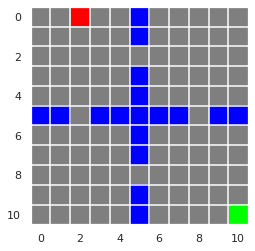

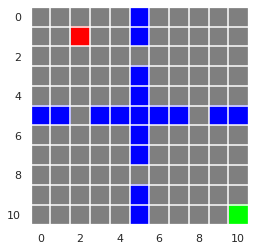

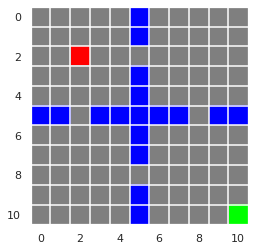

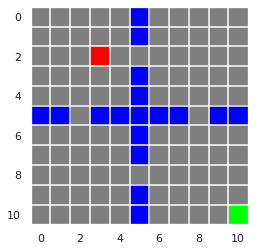

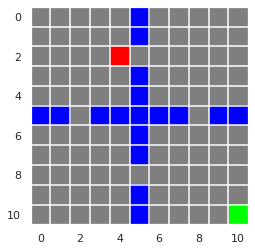

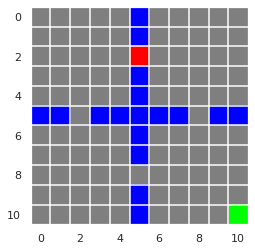

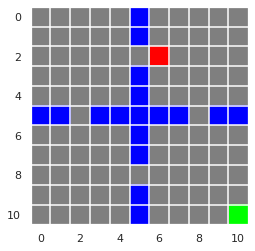

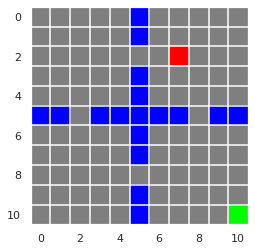

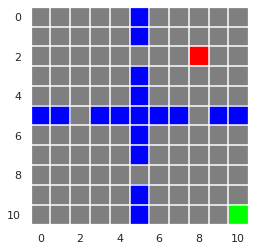

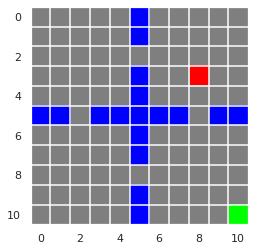

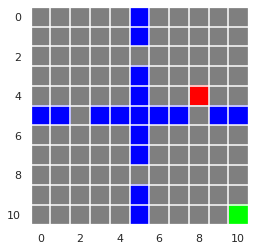

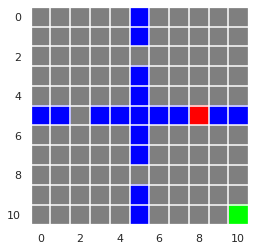

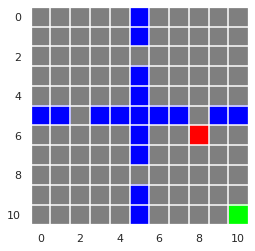

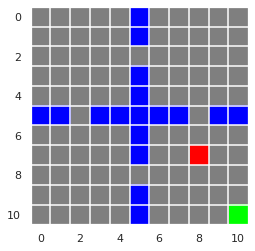

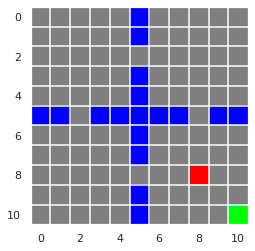

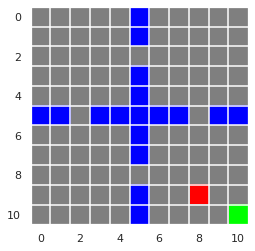

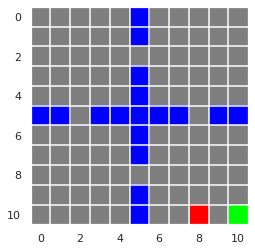

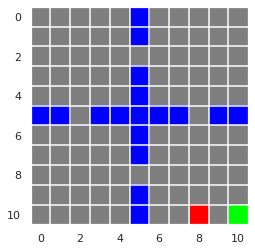

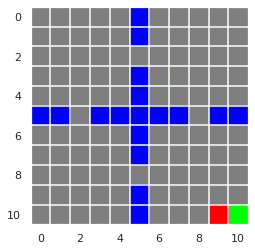

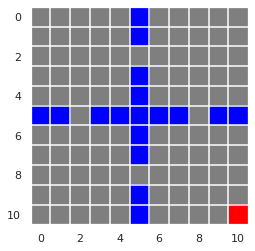

In [24]:
param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[10,10] ],
    "reward_minmax":[0.,0.],
    "reward_user_defined":False,
    "reward_pos":None,
    "grid_size" : 11,
    "pattern": "four_rooms",
    "obs_mode":"index",
}


env_name = "SimpleGrid"
env_change_reward = custom_env(env_name, param_env)


state = env_change_reward.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]
for i in range(22) : 
    env_change_reward.render()
    action = actions_down[i]
    next_state, reward, done, info = env_change_reward.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state

## functions simulations

In [25]:
def simu(env,param_agent,agent_LSFM = None, agent_Q = None) : 
    
    
    result_compile = []

    steps = 0
    render = param_agent["render"]

    reward_cumul = 0

    action_space = np.arange(env.action_space.n)
    possible_action = action_space

    
    memory = Memory(param_agent["memory"])
    memory_latent = Memory(param_agent["memory"])

    
    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0
    
    if agent_LSFM!= None : model_LSFM = agent_LSFM.model_LSFM
        
#     model_LSFM_prev= agent_LSFM.model_LSFM_prev
    if param_agent["train_LSFM"] == False : 
        model_Q = agent_Q.model
        model_Q_prev = agent_Q.model_prev
    
    for i in range(param_agent["num_episodes"]):
        state = env.reset()

        reward_ep_cumul = 0
        cnt = 0
        avg_loss = 0
        while True:
            if render:
                env.render()

            if param_agent["train_LSFM"] : 
                action, eps = agent_LSFM.choose_action_random()
                next_state, reward, done, info = env.step(action)
            else : 
                if param_agent["train_on_Q_latent"] : 
                    
                    state_resh = state.reshape(1,-1)
                    phi = agent_LSFM.model_LSFM(state_resh)["phi"]
                    state_latent = np.array(tf.reshape(phi, phi.shape[-1]))

                    # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                                        
                    action, eps = agent_Q.choose_action(
                                        state_latent, 
                                        model_Q, 
                                        steps, 
                                        possible_action
                                    )
                    
                    next_state, reward, done, info = env.step(action)

                    next_state_resh = next_state.reshape(1,-1)
                    phi_prime = agent_LSFM.model_LSFM(next_state_resh)["phi"]
                    next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))

                    
                else : 
                # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                    action, eps = agent_Q.choose_action(
                        state, 
                        model_Q, 
                        steps, 
                        possible_action
                    )

                    next_state, reward, done, info = env.step(action)


            if param_agent["RANDOM_REWARD_STD"] > 0:
                reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            reward_ep_cumul += reward
            reward_cumul += reward
            
            if done:
                next_state = np.zeros(env._state_dim)
                next_state_latent = np.zeros(param_agent["latent_space"])
            
            
            
            if param_agent["train"] :
                if param_agent["train_LSFM"] : 
                    memory.add_sample((state, action, reward, next_state, done))
                    loss_all = agent_LSFM.train_LSFM(
                        model_LSFM, 
                        memory, 
                        param_agent["filter_done"])

                    avg_loss += loss_all[0]
                    avg_loss_r += loss_all[1]
                    avg_loss_N += loss_all[2]
                    avg_loss_psi += loss_all[3]
                else : 
                    if param_agent["train_on_Q_latent"] : 
                        memory_latent.add_sample((state_latent, action, reward, next_state_latent, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory_latent, param_agent["filter_done"])
                        avg_loss += loss
                    else :                 
                        memory.add_sample((state, action, reward, next_state, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory, param_agent["filter_done"])
                        avg_loss += loss
                
            state = next_state
        
            steps += 1
            if steps % 1000 == 0 : print("steps : {}, episode : {}, eps : {}".format(steps, i, eps))
#             print("steps : {}, episode : {}".format(steps, i))
            if done:
                
                if cnt != 0:
                    avg_loss /= cnt
                    avg_loss_r /= cnt
                    avg_loss_N /= cnt
                    avg_loss_psi /= cnt
                    
                else:
                    avg_loss = 0
                result = [i, cnt, steps, reward_ep_cumul,
                          reward_cumul, eps, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi]
                if i % 1  == 0 : print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, eps: {:0.4f}, avg loss: {:0.4f}".format(*result))

                result_compile.append(result)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
    return result_compile
    
    


In [26]:
def experience(environment, param, agent= None, save_model = None) : 
    

    data = pd.DataFrame()
    
    for k in range(param["run"]) : 
                
        agent_Q_simu = Agent_Q(environment, param = param, save_model = save_model)      
        # Restore the weights
#         if save_model != None : 
#             for t in zip(agent_Q_simu.model.trainable_variables):
#                 print("agent_Q_simu", t)

        
        result_compile = simu(environment,param, agent, agent_Q_simu)
    

        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])

        data_train_df["carac"] = carac_model(param) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])

    return data, agent_Q_simu

## function plot

In [27]:
def plot_stat(data, param , col) : 
    stat = []
    stat_all = []
    for episode in range(param["num_episodes"]) : 

        mean = data.loc[lambda df: df['Episode'] == episode][col].mean()
        quantile10 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.1)
        quantile90 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.9)
        
        stat_all.append(data.loc[lambda df: df['Episode'] == episode][col].values   )

        stat.append([mean, quantile10, quantile90])
        
    data_stat = pd.DataFrame(stat, columns=[ "mean", "quantile10","quantile90"]     )
    


    # set seaborn style
    sns.set_theme()

    # Data
    x=range(param_agent_simu["num_episodes"])
    y=[ data_stat["quantile10"], data_stat["mean"], data_stat["quantile90"]]

    # Plot
    plt.stackplot(x,y, labels=['quantile10','mean','quantile90'])
    plt.legend(loc='upper left')
    plt.show()
    
    
    return data_stat, np.array(stat_all)

In [28]:
def box_plot(data,param, col) : 


    data_Q_episode_par_10 = pd.DataFrame()


    for k in range(0,param["num_episodes"], 10) : 
        data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                          data.loc[lambda df: df['Episode'] == k]])


    fig, axs = plt.subplots(1, 1,figsize=(15, 5))
    sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] )
    
    return data_Q_episode_par_10

In [29]:
def carac_model(param) : 
    if param["train_LSFM"] : calcul = "LSFM"
    else : 
        if param["train_on_Q_latent"]  : calcul = "Q_latent"
        else : calcul = "Q"
        if param["model_Q_Lin"]  : calcul+="_Lin"
        else : calcul+="_Deep"
    
    return calcul

## Train LSFM on random policy

### train

In [30]:
param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "num_episodes" : 200,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True,
    "render": False,
    "run": 15,
    
}

In [31]:
# %%time


# from itertools import product


# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["run"] = 10
# param_agent_simu["double_model"] = False




# params = {
#     "alpha_N" : [1e-2,1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
# #     "alpha_N" : [1e-1],
# #     "alpha_psi" : [1e-2]
# }
# combi_params = [dict(zip(params, v)) for v in product(*params.values())]

# results = []

# data_LSFM = pd.DataFrame()

# for params in combi_params : 
    
        
    
#     for key, value in params.items():
#         param_agent_simu[key] = value
    
#     for k in range(param_agent_simu["run"]) : 
#         param_agent_simu["reset_LSFM"] = True
        
        
#         agent = Agent(env, param_agent_simu)

#         result_compile = simu(env,param_agent_simu,agent) 
        
#         data_train_df = pd.DataFrame(result_compile, columns=[ 
#         "Episode", 
#         "Step", 
#         "cum_step",
#         "Reward", 
#         "Reward_cum",
#         "Eps",  
#         "Avg_loss" ,  
#         "Avg_loss_r",  
#         "Avg_loss_N",  
#         "Avg_loss_psi"])



#         data_train_df["carac"] = carac_model(param_agent_simu) 
#         data_train_df["param"] = str(params)    
#         data_LSFM = pd.concat([data_LSFM, data_train_df])

#         eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        

#         avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
#         avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
#         avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
#         avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

#         print("avg_loss", avg_loss)
#         print("avg_loss_r", avg_loss_r)
#         print("avg_loss_N", avg_loss_N)
#         print("avg_loss_psi", avg_loss_psi)

#         results.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

# results


# # data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", params ]     )

### eval the error on random sequence action

In [32]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )

In [33]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )
# col = "Avg_loss"
# df = data_results
# fig, axs = plt.subplots(1, 1,figsize=(10, 5))
# sns.boxplot( x=df["params"], y=df[col] )
# axs.set_xticklabels(df["params"].unique(),  rotation=30, ha= 'right');
# plt.ylim(0, 0.0001)

### train LSFM on best parameters

In [34]:
# data_LSFM.to_csv('data_LSFM.csv')

In [35]:
# data_results.to_csv('data_results.csv')

In [ ]:
%%time


from itertools import product


param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["run"] = 1
param_agent_simu["double_model"] = False

params = {
#     "alpha_N" : [1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
    "alpha_N" : [1e0],
    "alpha_psi" : [1e-2]
}
combi_params = [dict(zip(params, v)) for v in product(*params.values())]

results_best = []

data_LSFM_best = pd.DataFrame()

for params in combi_params : 
    
    for key, value in params.items():
        param_agent_simu[key] = value
    
    for k in range(param_agent_simu["run"]) : 
        param_agent_simu["reset_LSFM"] = True
        
        
        
        agent = Agent(env, param_agent_simu)
        result_compile = simu(env,param_agent_simu,agent) 
        
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])



        data_train_df["carac"] = carac_model(param_agent_simu) 
        data_train_df["param"] = str(params)    
        data_LSFM_best = pd.concat([data_LSFM_best, data_train_df])

        eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        
        
        
        
        fig, axs = plt.subplots(2, 3,figsize=(15, 10))
        plt.figure(figsize=(5, 5))
        sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,0] )
        sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, ax = axs[0,1] )
        sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df, ax = axs[0,2] )
        sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df, ax = axs[1,0] )
        plt.show()

        avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
        avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
        avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
        avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

        print("avg_loss", avg_loss)
        print("avg_loss_r", avg_loss_r)
        print("avg_loss_N", avg_loss_N)
        print("avg_loss_psi", avg_loss_psi)

        results_best.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

results_best

agent.model_LSFM.save('./agent_LSFM_model')

plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, label="Avg_loss" )
sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, label="Avg_loss_r" )
sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df , label="Avg_loss_N")
sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df , label="Avg_loss_psi")
plt.legend()
plt.show()



steps : 1000, episode : 0, eps : 1.0
Episode: 000, step: 1242, cumul_step: 1243, Reward: -543.7, Reward_cumul: -543.7, eps: 1.0000, avg loss: 0.0360
steps : 2000, episode : 1, eps : 1.0
steps : 3000, episode : 1, eps : 1.0
Episode: 001, step: 2006, cumul_step: 3250, Reward: -903.1, Reward_cumul: -1446.8, eps: 1.0000, avg loss: 0.0016
steps : 4000, episode : 2, eps : 1.0
Episode: 002, step: 1222, cumul_step: 4473, Reward: -689.5, Reward_cumul: -2136.3, eps: 1.0000, avg loss: 0.0004


## Q-learning

### Linear latent Q-learning 


 Train Q-function on __latent reward-predictive state space__ and on the _optimal policy_ to _maximize the dicounted sum of rewards_

#### original environment

In [ ]:
%%time
# choice of environement  : 
environment = env

# parameters of simulation : 
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001
# param_agent_simu["render"] =  False




# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model('./agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent)




In [ ]:

data_Q_lat_state  = data.copy()
data_Q_lat_state

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")

#### change in environment rewards

#### a refaire avec ["lambda"] =  0.0002

In [ ]:
%%time

# choice of environement  : 
environment = env_change_reward

# parameters of simulation : 
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0005


# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model('./agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent)




In [ ]:

data_Q_lat_state_change  = data.copy()
data_Q_lat_state_change

In [ ]:
# %%time
# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# param_agent_simu["train_LSFM"] = False
# param_agent_simu["double_model"] = True
# param_agent_simu["train_on_Q_latent"] = True
# param_agent_simu["model_Q_Lin"] = True
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

# param_agent_simu["reset_Q_model"] =  False
# param_agent_simu["run"] =  5

# param_agent_simu["reset_LSFM"] =  False

# data = pd.DataFrame()

# model_Q_copy = None
# environment = env_change_reward

# for k in range(param_agent_simu["run"]) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
    
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])

# data_Q_lat_state  = data.copy()
    

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "cum_step")
box_plot(data, param_agent_simu, "cum_step")

### Deep Q-learning  --- original state

#### original environment

In [ ]:
%%time

# choice of environement  : 
environment = env

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001

# load LSFM model : 
# agent = Agent(env, param_agent_simu)
# agent.model_LSFM = keras.models.load_model('./agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu)

# save model_Q
agent_Q.model.save('./agent_Q_model')









In [ ]:
# %%time

# param_agent_simu = param_agent.copy()

# param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
# param_agent_simu["double_model"] = True
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005
# param_agent_simu["run"] =  5

# param_agent_simu["reset_Q_model"] =  False

# data = pd.DataFrame()

# model_Q_copy = None
# environment = env

# for k in range(10) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
        
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])
    
    

# data_Deep_or_state  = data.copy()
    
# # fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# # sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# # sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

In [ ]:

data_Deep_or_state  = data.copy()
data_Deep_or_state

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")


#### change in environment rewards

In [ ]:

%%time

# choice of environement  : 
environment = env_change_reward

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  2
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001


# load LSFM model : 
# agent = Agent(env, param_agent_simu)
# agent.model_LSFM = keras.models.load_model('./agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, save_model = './agent_Q_model')

# save model_Q
# agent_Q.model.save('./agent_Q_model')





In [ ]:
data_Deep_or_state_change  = data.copy()
data_Deep_or_state_change

In [ ]:
# %%time

# param_agent_simu = param_agent.copy()

# param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
# param_agent_simu["double_model"] = True
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005
# param_agent_simu["run"] =  5

# param_agent_simu["reset_Q_model"] =  False

# data = pd.DataFrame()

# model_Q_copy = agent_Q.model
# environment = env_change_reward

# for k in range(param_agent_simu["run"]) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
        
    
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])
    
    

# data_Deep_or_state_change  = data.copy()
    
# # fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# # sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# # sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "cum_step")
box_plot(data, param_agent_simu, "cum_step")


# Clustering

## functions clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn import manifold

def kmeans(XStd, n_clusters, perplexity=None) : 

    print(__doc__)

    best_random_state = 0

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(XStd) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=best_random_state)
    cluster_labels = clusterer.fit_predict(XStd)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(XStd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(XStd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    if perplexity == None : perplexity = 100
        
    embedding = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca')
    # --- Visu 2d
    X_transformed = embedding.fit_transform(XStd)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #     centers = clusterer.cluster_centers_
    #     centers_transformed = embedding.fit_transform(centers)
    # Draw white circles at cluster centers
    #     ax2.scatter(centers_transformed[:, 0], centers_transformed[:, 1], marker='o',
    #                 c="white", alpha=1, s=200, edgecolor='k')

    #     for i, c in enumerate(centers_transformed):
    #         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    #     ax2.set_xlabel("Feature space for the 1st feature")
    #     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    return cluster_labels



In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def agglom(XStd, n_clusters, linkage = None, perplexity = None) : 
    print(__doc__)
    linkages = ["ward", "complete", "average", "single"]

    if linkage !=None : linkages = [linkage]

    for linkage in linkages:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        clusterer = AgglomerativeClustering(n_clusters= n_clusters   , linkage=linkage)
        cluster_labels = clusterer.fit_predict(XStd)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(XStd, cluster_labels)
        print("For linkages =", linkage,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(XStd, cluster_labels)

        y_lower = 10
        for i in range(len(np.unique(cluster_labels))):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) /  len(np.unique(cluster_labels)))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        if perplexity == None : perplexity = 100
        embedding = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca')
        # --- Visu 2d
        X_transformed = embedding.fit_transform(XStd)

        colors = cm.nipy_spectral(cluster_labels.astype(float) /  len(np.unique(cluster_labels)))
        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")

    plt.show()
    return cluster_labels

In [ ]:

param_agent_simu = {}
param_agent_simu = param_agent.copy()

# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model('./agent_LSFM_model')

model = agent.model_LSFM
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[2].output])


In [ ]:

state = env.reset()

n = env._state_dim  
# param_env["grid_size"]*param_env["grid_size"]

states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)

    
states = np.array(states)
phi = agent.model_LSFM(states)["phi"]

aux_model(states) == phi


In [ ]:
# choice of environement  : 
environment = env

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0002


agent_Q_simu = Agent_Q(environment, param = param_agent_simu, save_model = './agent_Q_model') 

model = agent_Q_simu.model
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_Q = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[0].output])

In [ ]:
states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)

    
states = np.array(states)
phi_Q = aux_model_Q(states)


## LSFM clustering

In [ ]:
# "ward", "complete", "average", "single"
XStd = phi
ncluster = param_agent_simu["latent_space"]

cluster_labels = agglom(XStd,ncluster, linkage = "ward", perplexity = 15)

cluster_labels_tab = cluster_labels.reshape(param_env["grid_size"],param_env["grid_size"])

state_dim = env._state_dim  



fig, ax = plt.subplots()
ax.imshow(cluster_labels_tab)

# Minor ticks
ax.set_xticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)
ax.set_yticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)


cluster_labels_tab, np.unique(cluster_labels)


## DQN clustering

In [ ]:
# "ward", "complete", "average", "single"
XStd = phi_Q
ncluster = param_agent_simu["latent_space"]

cluster_labels = agglom(XStd,ncluster, linkage = "ward", perplexity = 15)

cluster_labels_tab = cluster_labels.reshape(param_env["grid_size"],param_env["grid_size"])

state_dim = env._state_dim  



fig, ax = plt.subplots()
ax.imshow(cluster_labels_tab)

# Minor ticks
ax.set_xticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)
ax.set_yticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)


cluster_labels_tab, np.unique(cluster_labels)

# results

## compile results

### first environment : creation of latent space

In [ ]:
data_concat = pd.concat([data_Q_lat_state,data_Deep_or_state])
data_concat   

In [ ]:
col = "Reward_cum"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(1, 1,figsize=(5, 5))
# sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
#             hue=data_Q_episode_par_10[hue], 
#            saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y=col, hue=hue)


In [ ]:
col = "Step"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(3, 2,figsize=(12, 15))
# sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
#             hue=data_Q_episode_par_10[hue], 
#            saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Reward_cum", hue=hue, ax = axs[0,0])
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Reward", hue=hue, ax = axs[0,1])
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="cum_step", hue=hue, ax = axs[1,0])
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Step", hue=hue, ax = axs[1,1])
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Avg_loss", hue=hue, ax = axs[2,0])
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Eps", hue=hue, ax = axs[2,1])
# sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Reward_cum", hue=hue, ax = axs[0,1])
# axs.set(yscale="log")

### second environment :  use of previous latent spaces

In [ ]:
data_Q_lat_state_change["carac"] = "LSFNN"


In [ ]:
data_concat = pd.concat([data_Q_lat_state_change,data_Deep_or_state_change ])
data_concat   

In [ ]:
col = "cum_step"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(1, 1,figsize=(5, 5))
# sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
#             hue=data_Q_episode_par_10[hue], 
#            saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y=col, hue=hue)
axs.set(yscale="log")


In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(15, 10))

sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

## See results

In [ ]:
# data_Q_or_state.loc[lambda df: df['Episode'] == 0]

* Filter_done must be activate even for the learning of the LSFM model

In [ ]:
# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["num_episodes"] = 1
# param_agent_simu["policy"]["type"] = ["eps-greedy", "constant"]
# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.00
# param_agent_simu["train"]=False
# param_agent_simu["render"]=True
# simu(env,param_agent_simu,agent)


In [ ]:

# data_see_df = pd.DataFrame(result_compile, columns=[ "Episode", "Step", "cum_step", "Reward", "Reward_cum", "Avg_loss", "Eps"])


# data_see_df.to_csv('data_see_df.csv', sep='\t', encoding='utf-8')


# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 3,figsize=(15, 10))


# plt.figure(figsize=(5, 5))
# sns.lineplot(x="cum_step", y="Reward_cum", data=data_see_df, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Reward", data=data_see_df, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_see_df, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Eps", data=data_see_df, ax = axs[1,0] )

In [ ]:
# env.close()